In [20]:
import pandas as pd
p = 'Downloads/spam_ham_database.csv'
df = pd.read_csv(p)
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
display(df.head())


Columns: ['Unnamed: 0', 'label', 'text', 'label_num']
Shape: (5171, 4)


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [21]:
# choose text & label columns robustly
cols = [c.lower() for c in df.columns]

# candidates
text_candidates = [c for c in df.columns if c.lower() in ('text','message','v2','body','email','message_text','content')]
label_candidates = [c for c in df.columns if c.lower() in ('label','class','v1','target')]

print("Text candidates found:", text_candidates)
print("Label candidates found:", label_candidates)

# decide
text_col = text_candidates[0] if text_candidates else df.columns[1]   # fallback 2nd column
label_col = label_candidates[0] if label_candidates else df.columns[0] # fallback 1st column

print("Using text_col =", text_col, "and label_col =", label_col)

# create a clean DataFrame with expected column names
df = df[[text_col, label_col]].rename(columns={text_col: 'text', label_col: 'label'})
display(df.head())


Text candidates found: ['text']
Label candidates found: ['label']
Using text_col = text and label_col = label


,text,label
0,Subject: enron methanol ; meter # : 988291\r\n...,ham
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",ham
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",ham
3,"Subject: photoshop , windows , office . cheap ...",spam
4,Subject: re : indian springs\r\nthis deal is t...,ham


In [22]:
# If you used clean_text_no_stopwords earlier, replace with that name. Ensure it's defined.
# For safety, define a lightweight fallback clean_text if missing:
import re
def clean_text_fallback(s):
    if s is None: return ""
    s = str(s).lower()
    s = re.sub(r'https?://\S+|www\.\S+', ' urltoken ', s)
    s = re.sub(r'\S+@\S+\.\S+', ' emailtoken ', s)
    s = re.sub(r'\d+', ' numbertoken ', s)
    s = re.sub(r'[^a-z\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# pick your cleaning function; if you defined clean_text earlier, use that name
cleaner = globals().get('clean_text_no_stopwords', globals().get('clean_text', clean_text_fallback))

# apply label mapping robustly
df['label'] = df['label'].astype(str).str.strip().str.lower().map(lambda x: 1 if 'spam' in x or x=='1' else 0)
df['text_clean'] = df['text'].fillna('').apply(cleaner)

print("After cleaning, sample:")
display(df[['label','text','text_clean']].head())
print("Label value counts:", df['label'].value_counts())



After cleaning, sample:


,label,text,text_clean
0,0,Subject: enron methanol ; meter # : 988291\r\n...,subject enron methanol meter this is a follow ...
1,0,"Subject: hpl nom for january 9 , 2001\r\n( see...",subject hpl nom for january see attached file ...
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar...",subject neon retreat ho ho ho we re around to ...
3,1,"Subject: photoshop , windows , office . cheap ...",subject photoshop windows office cheap main tr...
4,0,Subject: re : indian springs\r\nthis deal is t...,subject re indian springs this deal is to book...


Label value counts: label
0    3672
1    1499
Name: count, dtype: int64


In [11]:
import re
from nltk.corpus import stopwords
import nltk

# Try downloading stopwords, but make it optional
try:
    nltk.download('stopwords')
    STOP = set(stopwords.words('english'))
except:
    STOP = set()  # fallback: no stopwords if download fails

def clean_text(s):
    s = str(s).lower()  # lowercase
    
    # remove URLs
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)
    
    # remove emails
    s = re.sub(r'\S+@\S+', ' ', s)
    
    # remove all characters except letters and spaces
    s = re.sub(r'[^a-z\s]', ' ', s)
    
    # collapse multiple spaces
    s = re.sub(r'\s+', ' ', s).strip()
    
    # remove stopwords (only if available)
    tokens = [w for w in s.split() if w not in STOP]
    
    return ' '.join(tokens)


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [23]:
# imports (run fresh)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics

# features & target
X = df['text_clean'].astype(str)   # ensure dtype
y = df['label'].astype(int)

# stratified split with reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', MultinomialNB())
])

# train
pipe.fit(X_train, y_train)
print("Pipeline trained. Vectorizer vocab size:", len(pipe.named_steps['tfidf'].vocabulary_))


Pipeline trained. Vectorizer vocab size: 5000


Accuracy: 0.936231884057971
              precision    recall  f1-score   support

         ham       0.98      0.93      0.95       735
        spam       0.85      0.95      0.90       300

    accuracy                           0.94      1035
   macro avg       0.91      0.94      0.93      1035
weighted avg       0.94      0.94      0.94      1035



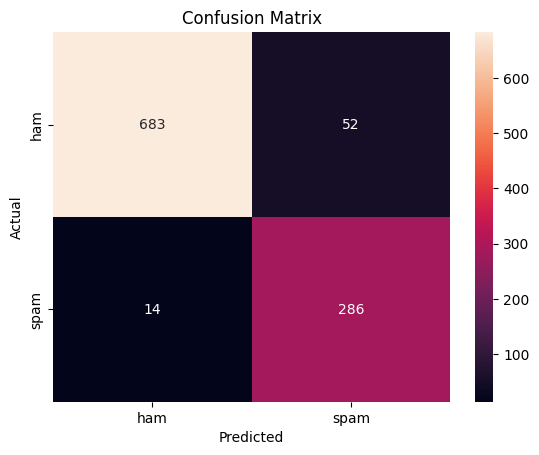

In [24]:
y_pred = pipe.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=['ham','spam']))

# confusion matrix
import seaborn as sns, matplotlib.pyplot as plt
cm = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()


In [25]:
import joblib
joblib.dump(pipe, "spam_pipeline.joblib")
print("Saved pipeline to spam_pipeline.joblib")


Saved pipeline to spam_pipeline.joblib
